In [1]:
# This is a example notebook

In [35]:
# ============================================
##1. Importación de librerías
# ============================================

# Librerías básicas
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import stats

# Configuraciones visuales
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [36]:
# ============================================
## 2. Carga de Datos
# ============================================

df = pd.read_csv("../data/raw/online_news_modified.csv")

print("=== REVISIÓN INICIAL ===")
print(f"Dimensiones: {df.shape}")
print(f"Memoria usada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar si hay duplicados
print(f"Filas duplicadas: {df.duplicated().sum()}")


=== REVISIÓN INICIAL ===
Dimensiones: (40436, 62)
Memoria usada: 135.84 MB
Filas duplicadas: 0


In [37]:
# ============================================
## 3. Revisión inicial de tipos de datos
# ============================================

def analizar_calidad_datos(df):
    """Función para análisis automático de calidad de datos"""
    print("\n=== ANÁLISIS DE CALIDAD DE DATOS ===")
    
    # 1. Valores nulos por columna
    nulos = df.isnull().sum()
    nulos_pct = (nulos / len(df)) * 100
    print("Valores nulos por columna:")
    for col in nulos[nulos > 0].index:
        print(f"  {col}: {nulos[col]} ({nulos_pct[col]:.2f}%)")
    
    # 2. Tipos de datos
    print(f"\nTipos de datos:")
    print(df.dtypes.value_counts())
    
    # 3. Columnas con un solo valor (constantes)
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        print(f"\nColumnas constantes (un solo valor): {constant_cols}")
    
    return nulos, constant_cols

nulos, constant_cols = analizar_calidad_datos(df)


=== ANÁLISIS DE CALIDAD DE DATOS ===
Valores nulos por columna:
  url: 409 (1.01%)
  timedelta: 442 (1.09%)
  n_tokens_title: 460 (1.14%)
  n_tokens_content: 473 (1.17%)
  n_unique_tokens: 451 (1.12%)
  n_non_stop_words: 459 (1.14%)
  n_non_stop_unique_tokens: 480 (1.19%)
  num_hrefs: 450 (1.11%)
  num_self_hrefs: 448 (1.11%)
  num_imgs: 456 (1.13%)
  num_videos: 449 (1.11%)
  average_token_length: 405 (1.00%)
  num_keywords: 455 (1.13%)
  data_channel_is_lifestyle: 475 (1.17%)
  data_channel_is_entertainment: 485 (1.20%)
  data_channel_is_bus: 407 (1.01%)
  data_channel_is_socmed: 492 (1.22%)
  data_channel_is_tech: 443 (1.10%)
  data_channel_is_world: 452 (1.12%)
  kw_min_min: 452 (1.12%)
  kw_max_min: 464 (1.15%)
  kw_avg_min: 471 (1.16%)
  kw_min_max: 441 (1.09%)
  kw_max_max: 405 (1.00%)
  kw_avg_max: 478 (1.18%)
  kw_min_avg: 432 (1.07%)
  kw_max_avg: 440 (1.09%)
  kw_avg_avg: 401 (0.99%)
  self_reference_min_shares: 439 (1.09%)
  self_reference_max_shares: 464 (1.15%)
  self_re

In [38]:
# ============================================
# 4.  Limpieza de datos 
# ============================================

# Eliminar columnas constantes (si las hay)
if constant_cols:
    df_clean = df.drop(columns=constant_cols)
    print(f"Eliminadas {len(constant_cols)} columnas constantes")
else:
    df_clean = df.copy()

# Convertir a numérico 
cols_to_convert = [col for col in df_clean.columns if col not in ['url', 'timedelta']]

for col in cols_to_convert:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Manejar valores nulos después de la conversión
print("\n=== MANEJO DE VALORES NULOS ===")
nulos_despues = df_clean.isnull().sum().sum()
if nulos_despues > 0:
    print(f"Valores nulos totales después de conversión: {nulos_despues}")
    
    # Estrategia: eliminar filas con >50% de valores nulos
    umbral_nulos = 0.5 * len(df_clean.columns)
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= umbral_nulos]
    print(f"Filas después de eliminar las con muchos nulos: {len(df_clean)}")
    
    # Para las restantes, imputar con mediana (solo columnas numéricas)
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
    print("Valores nulos restantes imputados con mediana")


=== MANEJO DE VALORES NULOS ===
Valores nulos totales después de conversión: 48442
Filas después de eliminar las con muchos nulos: 40436
Valores nulos restantes imputados con mediana


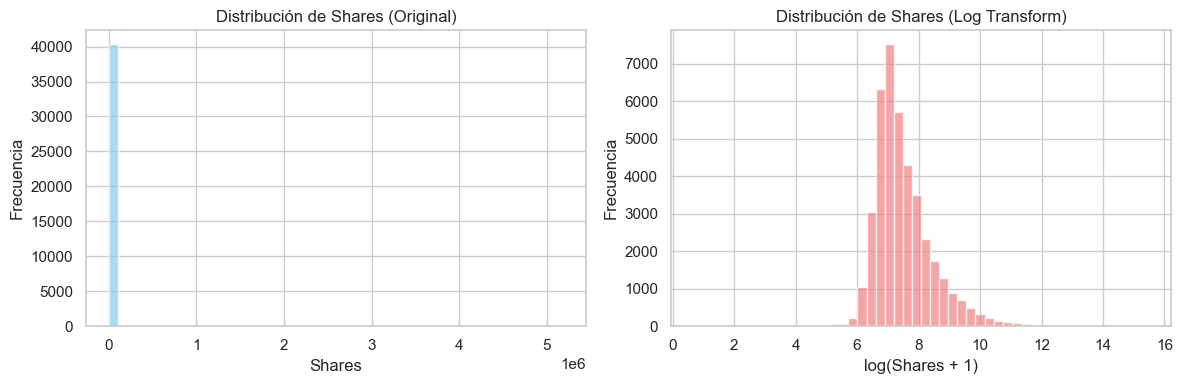

In [39]:
# ============================================
# 5. Visualización de outliers 
# ============================================

if 'shares' in df_clean.columns:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_clean['shares'], bins=50, alpha=0.7, color='skyblue')
    plt.title('Distribución de Shares (Original)')
    plt.xlabel('Shares')
    plt.ylabel('Frecuencia')
    
    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(df_clean['shares']), bins=50, alpha=0.7, color='lightcoral')
    plt.title('Distribución de Shares (Log Transform)')
    plt.xlabel('log(Shares + 1)')
    plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()


In [40]:
# ============================================
# 6. Detección y tratamiento de outliers
# ============================================

def tratar_outliers_iqr(df, columnas, factor=1.5):
    """
    Trata outliers columna por columna sin eliminar filas completas
    """
    df_temp = df.copy()
    outliers_info = {}
    
    for col in columnas:
        Q1 = df_temp[col].quantile(0.25)
        Q3 = df_temp[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Identificar outliers
        outliers_mask = (df_temp[col] < lower_bound) | (df_temp[col] > upper_bound)
        n_outliers = outliers_mask.sum()
        
        # Estrategia: caping (limitar los valores)
        if n_outliers > 0:
            df_temp[col] = np.where(df_temp[col] < lower_bound, lower_bound, df_temp[col])
            df_temp[col] = np.where(df_temp[col] > upper_bound, upper_bound, df_temp[col])
            
        outliers_info[col] = {
            'n_outliers': n_outliers,
            'pct_outliers': (n_outliers / len(df_temp)) * 100,
            'original_shape': df.shape[0]
        }
    
    return df_temp, outliers_info

# Aplicar solo a columnas numéricas (excluyendo posiblemente la target)
numeric_cols_clean = df_clean.select_dtypes(include=[np.number]).columns
# Excluir columnas que no queremos tratar como outliers
cols_to_exclude = ['url', 'timedelta', 'shares']  # ajusta según necesidad
cols_for_outliers = [col for col in numeric_cols_clean if col not in cols_to_exclude]

df_clean, outliers_info = tratar_outliers_iqr(df_clean, cols_for_outliers)

print("\n=== RESUMEN DE OUTLIERS ===")
for col, info in list(outliers_info.items())[:10]:  # mostrar primeras 10
    if info['n_outliers'] > 0:
        print(f"{col}: {info['n_outliers']} outliers ({info['pct_outliers']:.2f}%)")



=== RESUMEN DE OUTLIERS ===
n_tokens_title: 562 outliers (1.39%)
n_tokens_content: 2142 outliers (5.30%)
n_unique_tokens: 2019 outliers (4.99%)
n_non_stop_words: 3289 outliers (8.13%)
n_non_stop_unique_tokens: 2133 outliers (5.28%)
num_hrefs: 2561 outliers (6.33%)
num_self_hrefs: 2461 outliers (6.09%)
num_imgs: 8019 outliers (19.83%)
num_videos: 3181 outliers (7.87%)
average_token_length: 2078 outliers (5.14%)


In [41]:
# ============================================
# 7. Verificación final
# ============================================

print("\n" + "="*50)
print("RESUMEN FINAL DE LA LIMPIEZA")
print("="*50)
print(f"Dataset original: {df.shape}")
print(f"Dataset limpio: {df_clean.shape}")
print(f"Filas eliminadas: {df.shape[0] - df_clean.shape[0]} ({(1 - df_clean.shape[0]/df.shape[0])*100:.2f}%)")
print(f"Columnas finales: {df_clean.shape[1]}")

# Estadísticas básicas del dataset limpio
print("\nEstadísticas descriptivas (primeras 10 columnas):")
print(df_clean.describe().T.head(10))

##Guardar dataset limpio 
df_clean.to_csv('../data/interim/online_news_modified_cleaned_interim_20251010.csv', index=False)
print("\nDataset limpio guardado como 'online_news_modified_cleaned_interim_20251010.csv'")



RESUMEN FINAL DE LA LIMPIEZA
Dataset original: (40436, 62)
Dataset limpio: (40436, 62)
Filas eliminadas: 0 (0.00%)
Columnas finales: 62

Estadísticas descriptivas (primeras 10 columnas):
                            count        mean           std       min  \
n_tokens_title            40436.0   10.448363  2.164067e+00  4.500000   
n_tokens_content          40436.0  523.060342  3.687443e+02  0.000000   
n_unique_tokens           40436.0    0.540983  1.120512e-01  0.267585   
n_non_stop_words          40436.0    1.000000  3.498120e-09  1.000000   
n_non_stop_unique_tokens  40436.0    0.689282  1.071182e-01  0.436031   
num_hrefs                 40436.0   10.168835  7.928249e+00  0.000000   
num_self_hrefs            40436.0    3.004810  2.357990e+00  0.000000   
num_imgs                  40436.0    2.764430  3.175369e+00  0.000000   
num_videos                40436.0    0.537578  8.067762e-01  0.000000   
average_token_length      40436.0    4.670645  3.054893e-01  3.919052   

        

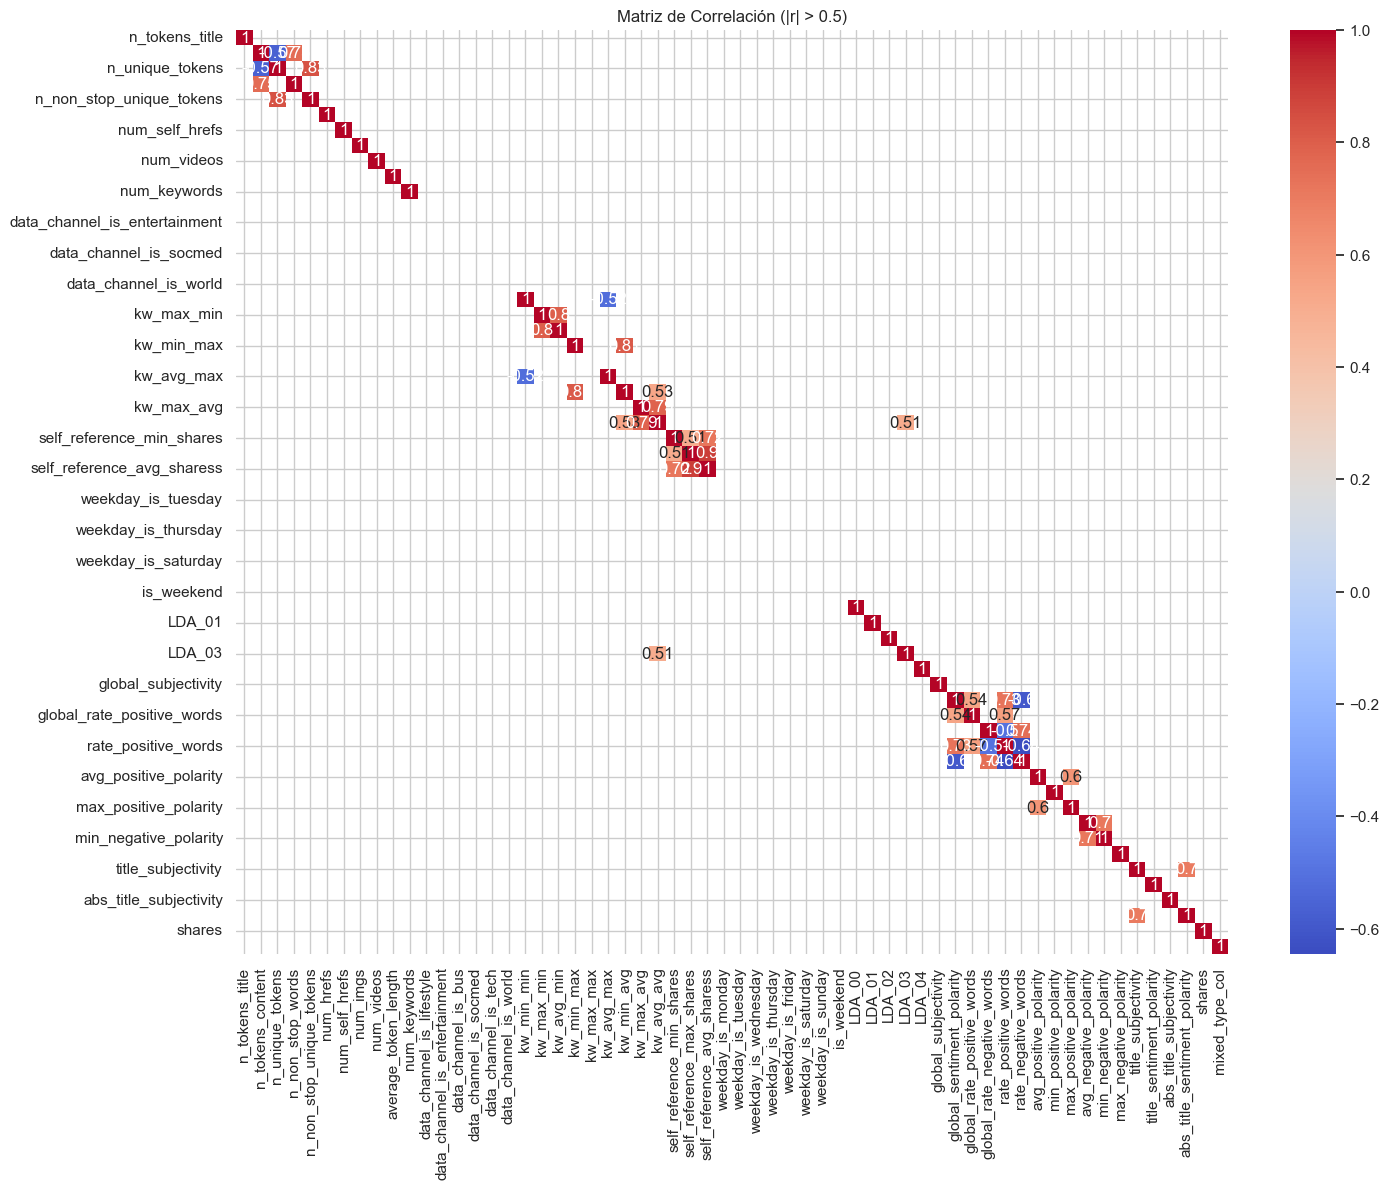

In [42]:
# ============================================
#  8: EDA Técnico (Correlaciones)
# ============================================

# Matriz de correlación
plt.figure(figsize=(16, 12))
correlation_matrix = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix[abs(correlation_matrix) > 0.5], annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (|r| > 0.5)')
plt.show()

# Identificar features altamente correlacionados
high_corr_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_features.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

In [43]:
# ============================================
#  9: Preprocesamiento y Feature Engineering
# ============================================

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Separar features y target
X = df_clean.drop('shares', axis=1)
y = df_clean['shares']

# Escalado de features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))

# PCA para reducción de dimensionalidad
pca = PCA(n_components=0.95)  # Mantener 95% de varianza
X_pca = pca.fit_transform(X_scaled)
print(f"Features originales: {X_scaled.shape[1]}")
print(f"Features después de PCA: {X_pca.shape[1]}")

Features originales: 59
Features después de PCA: 31


In [44]:
# ============================================
#  10: División de Datos
# ============================================
from sklearn.model_selection import train_test_split

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5)  # estratificar por shares
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (32348, 31), Test: (8088, 31)


In [45]:
# -----------------------------------------------------
# 11. Análisis de columnas no numericas
# -----------------------------------------------------

print("=== INICIANDO ACTIVIDADES DE DATA ENGINEERING ===")

print("\n11.ANALIZANDO COLUMNAS NO NUMÉRICAS")

# Identificar qué columnas tenemos realmente
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"Columnas numéricas: {len(numeric_cols)}")
print(f"Columnas no numéricas: {len(non_numeric_cols)}")
print(f"Columnas no numéricas: {non_numeric_cols}")

# Excluir target
if 'shares' in numeric_cols:
    numeric_cols.remove('shares')

=== INICIANDO ACTIVIDADES DE DATA ENGINEERING ===

11.ANALIZANDO COLUMNAS NO NUMÉRICAS
Columnas numéricas: 60
Columnas no numéricas: 2
Columnas no numéricas: ['url', 'timedelta']


In [46]:
# -----------------------------------------------------
# 12. Transformación de columnas categóricas
# -----------------------------------------------------

print("\n12.TRANSFORMANDO COLUMNAS CATEGÓRICAS")

df_engineered = df_clean.copy()

# Transformar 'url' en feature útil
if 'url' in df_engineered.columns:
    print("   Transformando 'url'...")
    # Extraer dominio
    df_engineered['url_domain'] = df_engineered['url'].str.extract(r'://([^/]+)')
    df_engineered['url_domain'] = df_engineered['url_domain'].fillna('unknown')
    
    # Codificar dominios más comunes
    from sklearn.preprocessing import LabelEncoder
    domain_counts = df_engineered['url_domain'].value_counts()
    common_domains = domain_counts[domain_counts > 50].index
    df_engineered['url_domain_encoded'] = df_engineered['url_domain'].apply(
        lambda x: x if x in common_domains else 'other'
    )
    
    le = LabelEncoder()
    df_engineered['url_domain_encoded'] = le.fit_transform(df_engineered['url_domain_encoded'])

# Transformar 'timedelta' a numérica
if 'timedelta' in df_engineered.columns:
    print("   Transformando 'timedelta'...")
    df_engineered['timedelta'] = pd.to_numeric(df_engineered['timedelta'], errors='coerce')
    df_engineered['timedelta'] = df_engineered['timedelta'].fillna(df_engineered['timedelta'].median())


12.TRANSFORMANDO COLUMNAS CATEGÓRICAS
   Transformando 'url'...
   Transformando 'timedelta'...


In [47]:
# -----------------------------------------------------
# 3. Feature Engineering 
# -----------------------------------------------------

print("\n13. CREANDO NUEVAS FEATURES")

# Features basadas en dominio de noticias
df_engineered['content_complexity'] = df_engineered['n_unique_tokens'] / (df_engineered['n_tokens_content'] + 1)
df_engineered['media_ratio'] = (df_engineered['num_imgs'] + df_engineered['num_videos']) / (df_engineered['n_tokens_content'] + 1)
df_engineered['self_reference_ratio'] = df_engineered['num_self_hrefs'] / (df_engineered['num_hrefs'] + 1)
df_engineered['title_engagement'] = df_engineered['n_tokens_title'] * (1 + df_engineered['title_subjectivity'])

# Manejar valores infinitos
new_features = ['content_complexity', 'media_ratio', 'self_reference_ratio', 'title_engagement']
for feature in new_features:
    df_engineered[feature] = df_engineered[feature].replace([np.inf, -np.inf], np.nan)
    df_engineered[feature] = df_engineered[feature].fillna(df_engineered[feature].median())

print(f"   Nuevas features creadas: {new_features}")


13. CREANDO NUEVAS FEATURES
   Nuevas features creadas: ['content_complexity', 'media_ratio', 'self_reference_ratio', 'title_engagement']


In [48]:
# -----------------------------------------------------
# 14. Pipeline Automatizado
# -----------------------------------------------------

print("\n14. CREANDO PIPELINE AUTOMATIZADO")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Definir columnas finales
final_numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
if 'shares' in final_numeric_cols:
    final_numeric_cols.remove('shares')

# Pipeline para Data Engineering
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, final_numeric_cols)
    ])

data_engineering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, random_state=42))
])



14. CREANDO PIPELINE AUTOMATIZADO


In [49]:
# -----------------------------------------------------
# 15. Aplicar Pipeline a datos completos
# -----------------------------------------------------

print("\n15. APLICANDO PIPELINE A DATOS COMPLETOS")

X_final = df_engineered[final_numeric_cols]
y_final = df_engineered['shares']

# Aplicar pipeline
X_processed = data_engineering_pipeline.fit_transform(X_final)

print(f"   Shape final: {X_processed.shape}")
print(f"   Reducción: {len(final_numeric_cols)} -> {X_processed.shape[1]} features")


15. APLICANDO PIPELINE A DATOS COMPLETOS
   Shape final: (40436, 34)
   Reducción: 65 -> 34 features


In [50]:
# -----------------------------------------------------
# 16. Guardar artifacts de Data Engineering
# -----------------------------------------------------

print("\n16. GUARDANDO ARTIFACTS")

import joblib
import json
from datetime import datetime

# Guardar pipeline
joblib.dump(data_engineering_pipeline, '../models/01_data_engineering_pipeline_JLRL.joblib')

# Guardar dataset con engineering
df_engineered.to_csv('../data/processed/online_news_modified_engineered_processed_20251010.csv', index=False)

# Metadatos
metadata = {
    'timestamp': datetime.now().isoformat(),
    'data_engineer_activities': {
        'outlier_treatment': True,
        'missing_value_imputation': True,
        'categorical_encoding': True,
        'feature_engineering': True,
        'pipeline_creation': True,
        'dimensionality_reduction': True
    },
    'dataset_info': {
        'original_shape': df.shape,
        'engineered_shape': df_engineered.shape,
        'processed_shape': X_processed.shape,
        'new_features_created': new_features
    }
}

with open('../models/01_data_engineering_metadata_JLRL.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("   ✅ Pipeline guardado: '../models/01_data_engineering_pipeline_JLRL.joblib'")
print("   ✅ Dataset guardado: '../data/processed/online_news_modified_engineered_processed_20251010.csv'")
print("   ✅ Metadatos guardados: '../models/01_data_engineering_metadata_JLRL.json'")


16. GUARDANDO ARTIFACTS
   ✅ Pipeline guardado: '../models/01_data_engineering_pipeline_JLRL.joblib'
   ✅ Dataset guardado: '../data/processed/online_news_modified_engineered_processed_20251010.csv'
   ✅ Metadatos guardados: '../models/01_data_engineering_metadata_JLRL.json'


In [51]:
# -----------------------------------------------------
# 17. División final con datos completos
# -----------------------------------------------------

print("\n17. DIVISIÓN FINAL DE DATOS")

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_processed, y_final, 
    test_size=0.2, 
    random_state=42, 
    stratify=pd.qcut(y_final, q=5)
)

print(f"   X_train: {X_train_final.shape}")
print(f"   X_test: {X_test_final.shape}")
print(f"   y_train: {y_train_final.shape}") 
print(f"   y_test: {y_test_final.shape}")


17. DIVISIÓN FINAL DE DATOS
   X_train: (32348, 34)
   X_test: (8088, 34)
   y_train: (32348,)
   y_test: (8088,)


In [52]:
# ============================================
# 18. Resumen Final
# ============================================

print("\n" + "="*60)
print("DATA ENGINEERING COMPLETADO")
print("="*60)
print(f"Dataset original: {df.shape}")
print(f"Dataset con engineering: {df_engineered.shape}")  
print(f"Datos procesados: {X_processed.shape}")
print(f"Nuevas features: {len(new_features)}")
print(f"Artifacts guardados: 3 archivos")
print("="*60)


DATA ENGINEERING COMPLETADO
Dataset original: (40436, 62)
Dataset con engineering: (40436, 68)
Datos procesados: (40436, 34)
Nuevas features: 4
Artifacts guardados: 3 archivos
